# Paper math
> Sanity checking all derivations for the manuscript

In [1]:
# np, pd, plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(plt.matplotlib.matplotlib_fname())

import aptr


/home/phil/aptr/notebooks/paper/matplotlibrc


In [2]:
db = aptr.database.RnaDB()

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


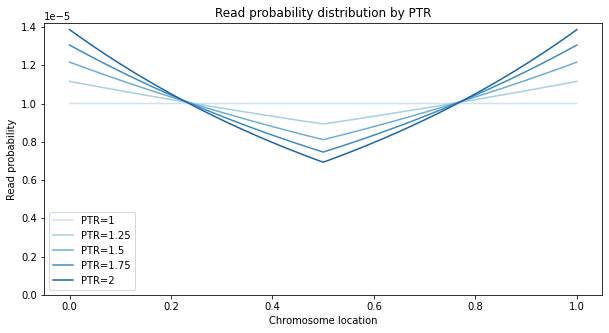

In [3]:
# Figure to show probability density functions of PTR

from aptr.simulation_new import _exact_coverage_curve

x = np.linspace(0, 1, 100000)
dists = aptr.oor_distance(x)

fig = plt.figure(figsize=(10, 5))
# Shades of blue
colors = plt.cm.Blues(np.linspace(0.2, 0.8, 5))
for ptr, color in zip([1, 1.25, 1.5, 1.75, 2], colors):
    y = _exact_coverage_curve(log2_ptr=np.log2(ptr), distances=dists)
    y /= np.sum(y)
    plt.plot(x, y[0,:], label=f"PTR={ptr}", color=color)
plt.ylim(0, plt.ylim()[1])
plt.xlabel("Chromosome location")
plt.ylabel("Read probability")
plt.title("Read probability distribution by PTR")
plt.legend()
plt.show()

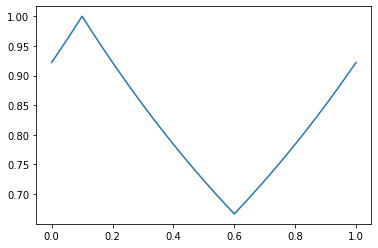

In [4]:
# Verify math

# Declare variables
abundance = 10
ptr = 1.5
logptr = np.log2(ptr)
oor = 0.1
size = 100000
x = np.linspace(0, 1, size)
dists = aptr.oor_distance(x, oor=oor, size=1)

# coverage functions
y = _exact_coverage_curve(log2_ptr=logptr, distances=dists)
plt.plot(x, y.flatten())

In [5]:
deltas = dists / 2 # Denormalize

y2 = np.exp2(-logptr * 2 * deltas)
assert np.allclose(y, y2)

y3 = ptr ** (-2 * deltas)
assert np.allclose(y, y3)

In [25]:
# Verify C @ A * torch.exp2(1 - D @ B) == C @ A * torch.exp2(-D @ B)

n = 10
m = 50
k = 30
s = 20

A = np.random.rand(n, s)
B = np.random.rand(n, s)
C = np.random.rand(m, n)
D = np.random.rand(m, n)
E = np.random.rand(k, m)

G1 = C @ A * np.exp2(1 - D @ B)
G2 = C @ A * np.exp2(-D @ B)

assert np.allclose(G1/G1.sum(axis=0), G2/G2.sum(axis=0))


In [56]:
# Sanity check gradient of loss function
import torch

# At = torch.tensor(A, dtype=torch.float32, requires_grad=True)
# Bt = torch.tensor(B, dtype=torch.float32, requires_grad=True)
# Ct = torch.tensor(C, dtype=torch.float32, requires_grad=True)
# Dt = torch.tensor(D, dtype=torch.float32, requires_grad=True)
# Et = torch.tensor(E, dtype=torch.float32, requires_grad=True)

# Gt = Et @ (Ct @ At * torch.exp2(- Dt @ Bt))
Gt = torch.tensor(E @ G2, dtype=torch.float32, requires_grad=True)
Gt.requires_grad = True

S = torch.tensor(np.random.poisson(lam=E @ G2), dtype=torch.float32)

loss = torch.nn.PoissonNLLLoss(log_input=False)(Gt, S)
loss.backward()

# Verify that the gradient is correct
# print(At.grad)
# print(Bt.grad)
dloss_dGt = (1 - (S / Gt)) / (k * s)
# print(Gt.grad)
Gt.grad / dloss_dGt

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0